# EDA - Disneyland Reviews
---

Executed on Colab

Brief description

## Setup

In [ ]:
# Set root directory in Google colab (or local)
DIR_ROOT = '/content/drive/MyDrive/Vanderbilt - MSDS/Second Year/big_data_scaling/project'

In [1]:
# # Setting up Spark + Geopandas on **Colab**
!pip install geopandas
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq

In [ ]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Spark
import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

# Google Colab
from google.colab import drive

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

In [ ]:
# Google Colab authentication
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Update directory after Google Colab auth
os.chdir(DIR_ROOT)
%pwd

/content/drive/MyDrive/Vanderbilt - MSDS/Second Year/big_data_scaling/project


## Load Data + First Look
---

Initializing Spark and getting the first look at our data. `Review_ID` is the unique identifier for each record. In reviewing the output of `describe.show()` we will have to handle missing values and strange characters

In [ ]:
# create the session (config info)
conf = SparkConf().set("spark.ui.port", "4050")

# create the context
sc = pyspark.SparkContext.getOrCreate(conf=conf)
spark = SparkSession.builder.getOrCreate()

In [ ]:
df_disney = spark.read.csv("data/DisneylandReviews.csv", header=True)

df_disney.show(5)

+---------+------+----------+--------------------+--------------------+-------------------+
|Review_ID|Rating|Year_Month|   Reviewer_Location|         Review_Text|             Branch|
+---------+------+----------+--------------------+--------------------+-------------------+
|670772142|     4|    2019-4|           Australia|If you've ever be...|Disneyland_HongKong|
|670682799|     4|    2019-5|         Philippines|Its been a while ...|Disneyland_HongKong|
|670623270|     4|    2019-4|United Arab Emirates|Thanks God it was...|Disneyland_HongKong|
|670607911|     4|    2019-4|           Australia|HK Disneyland is ...|Disneyland_HongKong|
|670607296|     4|    2019-4|      United Kingdom|the location is n...|Disneyland_HongKong|
+---------+------+----------+--------------------+--------------------+-------------------+
only showing top 5 rows



In [ ]:
# General Info
# --------------------------------------
df_disney.describe().show()

+-------+--------------------+-----------------+----------+-----------------+--------------------+--------------------+
|summary|           Review_ID|           Rating|Year_Month|Reviewer_Location|         Review_Text|              Branch|
+-------+--------------------+-----------------+----------+-----------------+--------------------+--------------------+
|  count|               42656|            42656|     42656|            42656|               42656|               42656|
|   mean|3.1885526982837117E8|4.217695048762191|      null|             null|                null|                null|
| stddev| 1.657092242602845E8|1.063371068901573|      null|             null|                null|                null|
|    min|           100034342|                1|   2010-10|      Afghanistan|                 ...|Disneyland_Califo...|
|    max|            99885941|                5|   missing|    �land Islands|you will travel i...|    Disneyland_Paris|
+-------+--------------------+----------

In [ ]:
# Number of reviews by location
# --------------------------------------
df_disney.select('Branch', 'Rating').groupby('Branch').count().show()

+--------------------+-----+
|              Branch|count|
+--------------------+-----+
| Disneyland_HongKong| 9620|
|    Disneyland_Paris|13630|
|Disneyland_Califo...|19406|
+--------------------+-----+



In [ ]:
# TOP COUNTRIES WITH REVIEWS
# --------------------------------------
(df_disney.select('Reviewer_Location', 'Rating')
  .groupby('Reviewer_Location')
  .count()
  .sort(col("count").desc())
  .show(10)
)

+-----------------+-----+
|Reviewer_Location|count|
+-----------------+-----+
|    United States|14551|
|   United Kingdom| 9751|
|        Australia| 4679|
|           Canada| 2235|
|            India| 1511|
|      Philippines| 1070|
|        Singapore| 1037|
|      New Zealand|  756|
|         Malaysia|  588|
|        Hong Kong|  554|
+-----------------+-----+
only showing top 10 rows



### Fix + Drop Missing Data!

Update any missing/null values to be consistnet (e.g. np.nan isntead of 'missing'). This will make it easier to drop them since it is such a small percentage of the overall dataset (~6%)

In [ ]:
# Fix Missing Values in Year/Month
df_disney = df_disney.withColumn('Year_Month',
                                 when(col('Year_Month') == 'missing',np.nan).otherwise(col('Year_Month')))


# Drop missing records. around ~6% (~2.6k)
df_disney = df_disney.filter(df_disney.Year_Month != '')


### Clean Up Year/Month and Branch Name

1. Separate Year and Month to make it easier to separately analyze each year (time-series) and month (time of year).
2. Clean up branch name since they are all prepended by `Disneyland_`, and we don't care about that :) -- We know it's already a Disneyland
3. Create a separate PySpark DataFrame of only Serbian reviews to use later

In [ ]:
# Create Year, Month column
df_disney = df_disney.withColumn('Year', 
                                 when(col('Year_Month').isNotNull(), 
                                      substring('Year_Month', 1, 4)).otherwise(None)
                                 )

df_disney = df_disney.withColumn('Month', 
                                 when(col('Year_Month').isNotNull(), 
                                      substring('Year_Month', 6, 50)).otherwise(None)
                                 )

In [ ]:
# Clean Branch Name
df_disney = df_disney.withColumn('Branch_Clean', substring('Branch', 12, 50))

In [ ]:
df_serbia = df_disney.filter(df_disney.Reviewer_Location == 'Serbia')
# df_serbia.registerTempTable("Disney_Serbian_Reviews")

## Feature Engineering
---

Using PySpark SQL to make data manipulations as part of our EDA

In [ ]:
# Register table
df_disney.registerTempTable("Disney_Ratings_Base")


In [ ]:
spark.sql("SELECT * FROM Disney_Ratings_Base LIMIT 5").show()

+---------+------+----------+--------------------+--------------------+-------------------+----+-----+------------+
|Review_ID|Rating|Year_Month|   Reviewer_Location|         Review_Text|             Branch|Year|Month|Branch_Clean|
+---------+------+----------+--------------------+--------------------+-------------------+----+-----+------------+
|670772142|     4|    2019-4|           Australia|If you've ever be...|Disneyland_HongKong|2019|    4|    HongKong|
|670682799|     4|    2019-5|         Philippines|Its been a while ...|Disneyland_HongKong|2019|    5|    HongKong|
|670623270|     4|    2019-4|United Arab Emirates|Thanks God it was...|Disneyland_HongKong|2019|    4|    HongKong|
|670607911|     4|    2019-4|           Australia|HK Disneyland is ...|Disneyland_HongKong|2019|    4|    HongKong|
|670607296|     4|    2019-4|      United Kingdom|the location is n...|Disneyland_HongKong|2019|    4|    HongKong|
+---------+------+----------+--------------------+--------------------+-

### Ratings + Location
---

`Disney_Branch_Ratings` -- Intermediate table. Number of reviews for each rating (1-5) at each branch/location

`Disney_Total_Ratings` -- Intermediate table. Total number of reivews by branch/location

`disney_branch_main` -- `Disney_Branch_Ratings` but with the rating percentage for each branch (`pct_rating`)

In [ ]:
query = """
SELECT Branch_Clean,
       Rating,
       count(*) as counts
FROM Disney_Ratings_Base
GROUP BY Branch_Clean, Rating
ORDER BY Branch_Clean, Rating ASC
"""

disney_branch_ratings = spark.sql(query)
disney_branch_ratings.registerTempTable('Disney_Branch_Ratings')

In [ ]:
query = """
SELECT Branch_Clean,
       count(*) as total_ratings
FROM Disney_Ratings_Base
GROUP BY Branch_Clean
ORDER BY Branch_Clean
"""

disney_total_ratings = spark.sql(query)
disney_total_ratings.registerTempTable('Disney_Total_Ratings')

In [ ]:
query = """
SELECT *,
       round(counts / total_ratings * 100, 2) as pct_rating
FROM Disney_Branch_Ratings
LEFT JOIN (Disney_Total_Ratings)
Using(Branch_Clean)
"""

disney_branch_main = spark.sql(query)
disney_branch_main.registerTempTable('disney_branch_main')

In [ ]:
disney_branch_main.show()

+------------+------+------+-------------+----------+
|Branch_Clean|Rating|counts|total_ratings|pct_rating|
+------------+------+------+-------------+----------+
|    HongKong|     5|  4338|         9147|     47.43|
|  California|     2|   685|        18202|      3.76|
|       Paris|     4|  3320|        12694|     26.15|
|       Paris|     1|   736|        12694|       5.8|
|  California|     1|   450|        18202|      2.47|
|       Paris|     5|  5768|        12694|     45.44|
|  California|     4|  3713|        18202|      20.4|
|    HongKong|     1|   152|         9147|      1.66|
|  California|     3|  1552|        18202|      8.53|
|       Paris|     3|  1933|        12694|     15.23|
|    HongKong|     2|   307|         9147|      3.36|
|  California|     5| 11802|        18202|     64.84|
|       Paris|     2|   937|        12694|      7.38|
|    HongKong|     3|  1297|         9147|     14.18|
|    HongKong|     4|  3053|         9147|     33.38|
+------------+------+------+

### Reviews by Month
----

Ratings by month and location -- overall and by each rating (1-5)


In [ ]:
# Month + Rating + Count
month_rating_query = """
SELECT DISTINCT Month
FROM Disney_Ratings_Base
ORDER BY Month
"""

branch_month_rating_query = """
SELECT Month,
       Branch_Clean,
       count(*) as total_reviews,
       SUM(if(Rating = '1', 1, 0)) AS rating_1,
       SUM(if(Rating = '2', 1, 0)) AS rating_2,
       SUM(if(Rating = '3', 1, 0)) AS rating_3,
       SUM(if(Rating = '4', 1, 0)) AS rating_4,
       SUM(if(Rating = '5', 1, 0)) AS rating_5
FROM Disney_Ratings_Base
GROUP BY Month, Branch_Clean
"""

query = f"""
SELECT *
FROM ({month_rating_query})
LEFT JOIN ({branch_month_rating_query})
USING(Month)
ORDER BY Branch_Clean, Month
"""

disney_month_ratings = spark.sql(query)
disney_month_ratings.registerTempTable('disney_month_ratings')

In [ ]:
disney_month_ratings.show(5)

+-----+------------+-------------+--------+--------+--------+--------+--------+
|Month|Branch_Clean|total_reviews|rating_1|rating_2|rating_3|rating_4|rating_5|
+-----+------------+-------------+--------+--------+--------+--------+--------+
|    1|  California|         1189|      34|      52|      97|     243|     763|
|   10|  California|         1776|      60|      69|     164|     376|    1107|
|   11|  California|         1179|      27|      31|      94|     207|     820|
|   12|  California|         1672|      49|      73|     157|     342|    1051|
|    2|  California|         1107|      29|      51|     108|     214|     705|
+-----+------------+-------------+--------+--------+--------+--------+--------+
only showing top 5 rows



### Reviews by Year
---
Same format as the monthly query/table above but now by Year!

In [ ]:
# Month + Rating + Count
year_rating_query = """
SELECT DISTINCT Year
FROM Disney_Ratings_Base
ORDER BY Year
"""

branch_year_rating_query = """
SELECT Year,
       Branch_Clean,
       count(*) as total_reviews,
       SUM(if(Rating = '1', 1, 0)) AS rating_1,
       SUM(if(Rating = '2', 1, 0)) AS rating_2,
       SUM(if(Rating = '3', 1, 0)) AS rating_3,
       SUM(if(Rating = '4', 1, 0)) AS rating_4,
       SUM(if(Rating = '5', 1, 0)) AS rating_5
FROM Disney_Ratings_Base
GROUP BY Year, Branch_Clean
"""


query = f"""
SELECT *
FROM ({year_rating_query})
LEFT JOIN ({branch_year_rating_query})
USING(Year)
ORDER BY Branch_Clean, Year
"""

disney_year_ratings = spark.sql(query)
disney_year_ratings.show(20)

disney_year_ratings.registerTempTable('disney_year_ratings')

+----+------------+-------------+--------+--------+--------+--------+--------+
|Year|Branch_Clean|total_reviews|rating_1|rating_2|rating_3|rating_4|rating_5|
+----+------------+-------------+--------+--------+--------+--------+--------+
|2010|  California|           72|       4|       0|       2|      12|      54|
|2011|  California|          953|      24|      26|      80|     154|     669|
|2012|  California|         2310|      36|      46|     143|     488|    1597|
|2013|  California|         2328|      39|      78|     179|     479|    1553|
|2014|  California|         2643|      58|     109|     220|     567|    1689|
|2015|  California|         3239|      74|     129|     277|     620|    2139|
|2016|  California|         2800|      70|     105|     252|     606|    1767|
|2017|  California|         2064|      64|      85|     241|     424|    1250|
|2018|  California|         1501|      68|      95|     135|     309|     894|
|2019|  California|          292|      13|      12| 

### Reviews by Country
---

Count of reviews (overall and by rating) by country

In [ ]:
sql_query = """
SELECT Reviewer_Location,
       count(*) as review_count,
       SUM(if(Rating = '1', 1, 0)) AS rating_1,
       SUM(if(Rating = '2', 1, 0)) AS rating_2,
       SUM(if(Rating = '3', 1, 0)) AS rating_3,
       SUM(if(Rating = '4', 1, 0)) AS rating_4,
       SUM(if(Rating = '5', 1, 0)) AS rating_5
FROM Disney_Ratings_Base
GROUP BY Reviewer_Location
"""

reivew_country_rating = spark.sql(sql_query)
reivew_country_rating.registerTempTable('reivew_country_rating')

In [ ]:
reivew_country_rating.show(5)

+-------------------+------------+--------+--------+--------+--------+--------+
|  Reviewer_Location|review_count|rating_1|rating_2|rating_3|rating_4|rating_5|
+-------------------+------------+--------+--------+--------+--------+--------+
|             Russia|          43|       3|       2|       3|      12|      23|
|U.S. Virgin Islands|           5|       0|       1|       1|       0|       3|
|            Senegal|           1|       0|       0|       0|       0|       1|
|             Sweden|          94|       9|       7|      13|      34|      31|
|        Philippines|        1024|      15|      20|      83|     323|     583|
+-------------------+------------+--------+--------+--------+--------+--------+
only showing top 5 rows



## EDA Visualizations
---

In order to plot, we have to convert the PySpark DataFrames into Pandas and then use MatPlotLib and/or Seaborn. Some data was restructured for plotting purposes.

In [ ]:
df_pandas = df_disney.toPandas()
df_pandas = df_pandas.drop(['Review_ID', 'Branch', 'Review_Text'], axis=1)

# Missing data (None) to NaN
df_pandas = df_pandas.fillna(value=np.nan)

In [ ]:
# DROP MISSING
df_pandas = df_pandas.dropna()

df_pandas['rating_numeric'] = df_pandas['Rating'].astype(int)

In [ ]:
df_pandas.head()

,Rating,Year_Month,Reviewer_Location,Year,Month,Branch_Clean,rating_numeric
0,4,2019-4,Australia,2019,4,HongKong,4
1,4,2019-5,Philippines,2019,5,HongKong,4
2,4,2019-4,United Arab Emirates,2019,4,HongKong,4
3,4,2019-4,Australia,2019,4,HongKong,4
4,4,2019-4,United Kingdom,2019,4,HongKong,4


### Distribution of Ratings
---

How were ratings distributed by each location

In [ ]:
df_rating_location = \
    df_pandas[['Branch_Clean', 'Rating', 'Year']].groupby(['Branch_Clean', 'Rating']).agg('count').reset_index()

# Count of reviews by location, by rating
df_rating_location = df_rating_location.rename(columns={'Year': 'Count'})

# # total number of reviews by location
df_rating_count = \
    df_rating_location[['Branch_Clean', 'Count']].groupby('Branch_Clean').agg('sum').reset_index()

In [ ]:
# Percent with rating
rating_dist = (df_pandas['Rating'].value_counts() / df_pandas.shape[0]).sort_index()

rating_dist

1    0.033414
2    0.048173
3    0.119422
4    0.251879
5    0.547112
Name: Rating, dtype: float64

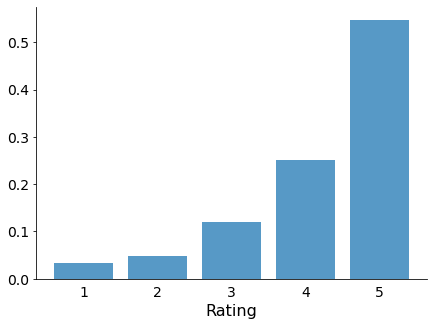

In [ ]:
# Percent with rating
# Base Plot
fig, ax = plt.subplots();
fig.set_size_inches(7, 5)

ax.bar(
    x = rating_dist.index.values,
    height = rating_dist.values,
    color='#5799C6');

# Styling
# ------------------------------------

## Border
right_side = ax.spines["right"]
right_side.set_visible(False)
top_side = ax.spines["top"]
top_side.set_visible(False)

# Axis
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False         # ticks along the top edge are off
)
plt.xlabel("Rating", fontsize=16)
ax.tick_params(axis="x", labelsize=14)
ax.tick_params(axis="y", labelsize=14)

# Save
plt.savefig('plots/review_distribution.png', dpi=140)

In [ ]:
ratings_by_branch = df_pandas[['Branch_Clean', 'Rating', 'rating_numeric']].groupby(['Branch_Clean', 'Rating']).count().reset_index()

In [ ]:
ratings_by_branch['ratings_pct'] =  0


ratings_by_branch['ratings_pct'] = \
    np.where(ratings_by_branch['Branch_Clean']=='California', ratings_by_branch['rating_numeric'] / 18202, ratings_by_branch['ratings_pct'])

ratings_by_branch['ratings_pct'] = \
    np.where(ratings_by_branch['Branch_Clean']=='HongKong', ratings_by_branch['rating_numeric'] / 9147, ratings_by_branch['ratings_pct'])

ratings_by_branch['ratings_pct'] = \
    np.where(ratings_by_branch['Branch_Clean']=='Paris', ratings_by_branch['rating_numeric'] / 12694, ratings_by_branch['ratings_pct'])


ratings_by_branch['ratings_pct'] = (ratings_by_branch['ratings_pct'] * 100).round(1)

In [ ]:
ratings_by_branch.head()

,Branch_Clean,Rating,rating_numeric,ratings_pct
0,California,1,450,2.5
1,California,2,685,3.8
2,California,3,1552,8.5
3,California,4,3713,20.4
4,California,5,11802,64.8


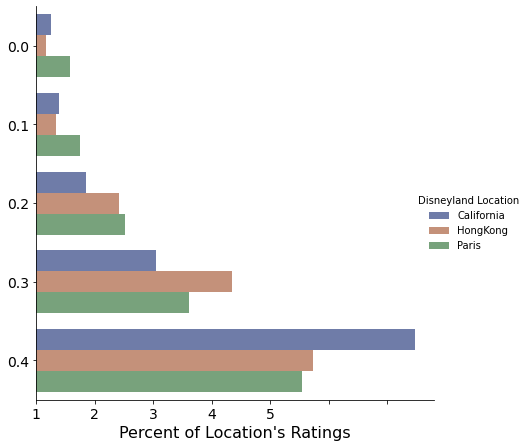

In [ ]:
g = sns.catplot(
    data = ratings_by_branch, 
    kind = "bar",
    y="Rating",
    x="ratings_pct",
    hue="Branch_Clean",
    palette="dark", alpha=.6, height=6
);

# Axis
axes = g.axes.flatten();
axes[0].set_ylabel("");
axes[0].set_xlabel("Percent of Location's Ratings", size=16);
axes[0].set_xticklabels(ax.get_xticklabels(), size=14);
axes[0].set_yticklabels(ax.get_yticklabels(), size=14);

# Legend
g._legend.set_title( 'Disneyland Location');
# plt.legend(fontsize='x-large', title_fontsize='40')
# plt.setp(g.get_legend().get_texts(), fontsize='10') 

# Save
g.savefig('plots/location_review_distribution.png', dpi=140)

In [ ]:
ratings_by_branch['Rating'] = ratings_by_branch['Rating'].astype(int)

In [ ]:
cut = 3

location_rating_good = ratings_by_branch.loc[ratings_by_branch['Rating'] > cut, ['Branch_Clean', 'rating_numeric', 'ratings_pct']]
location_rating_good = location_rating_good.groupby('Branch_Clean').sum().reset_index()
location_rating_good['rating'] = 'good'

location_rating_bad = ratings_by_branch.loc[ratings_by_branch['Rating'] <= cut, ['Branch_Clean', 'rating_numeric', 'ratings_pct']]
location_rating_bad = location_rating_bad.groupby('Branch_Clean').sum().reset_index()
location_rating_bad['rating'] = 'bad'

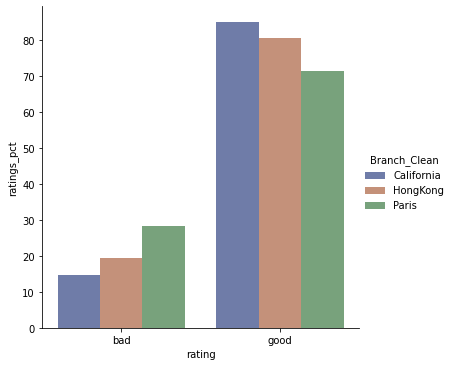

In [ ]:
df = pd.concat([location_rating_bad, location_rating_good])

sns.catplot(
    data = df, 
    kind = "bar",
    x="rating",
    y="ratings_pct",
    hue="Branch_Clean",
    palette="dark", alpha=.6, height=5
);

### Reviews By Month
---

Use `disney_month_ratings` to understand how the time of year impacts reviews!

In [ ]:
df_month_ratings = disney_month_ratings.toPandas()
df_month_ratings['Month'] = df_month_ratings['Month'].astype(int)
df_month_ratings = df_month_ratings.sort_values('Month')

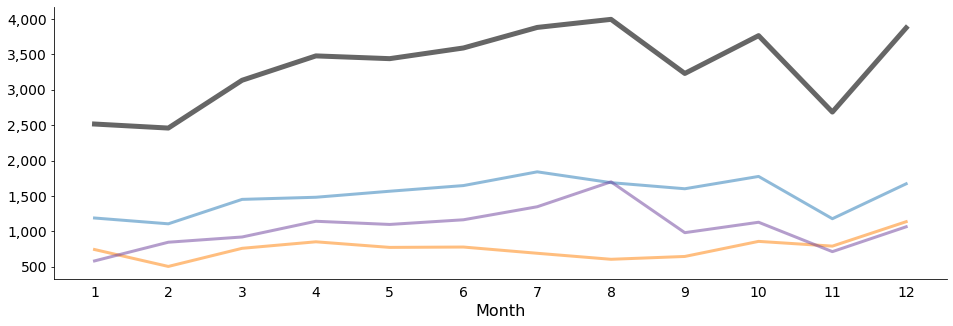

In [ ]:
# TOTAL REVIEWS - ALL LOCATIONS
# Base Plot
fig, ax = plt.subplots();
fig.set_size_inches(16, 5)

ax.plot(
    df_month_ratings.loc[df_month_ratings.Branch_Clean == 'California']['Month'],
    df_month_ratings.loc[df_month_ratings.Branch_Clean == 'California']['total_reviews'],
    label= 'California',
    linewidth = 3,
    alpha = 0.5,
    # linewidth = 5,
    color = "#2177B4"
);

ax.plot(
    df_month_ratings.loc[df_month_ratings.Branch_Clean == 'HongKong']['Month'],
    df_month_ratings.loc[df_month_ratings.Branch_Clean == 'HongKong']['total_reviews'],
    label= 'Hong Kong',
    linewidth = 3,
    alpha = 0.5,
    # linewidth = 5,
    color = "#FF7F00"
);

ax.plot(
    df_month_ratings.loc[df_month_ratings.Branch_Clean == 'Paris']['Month'],
    df_month_ratings.loc[df_month_ratings.Branch_Clean == 'Paris']['total_reviews'],
    label= 'Paris',
    linewidth = 3,
    alpha = 0.5,
    # linewidth = 5,
    color = "#6A3D9A"
);

ax.plot(
    df_month_ratings[['Month','total_reviews']].groupby('Month').sum().reset_index()['Month'],
    df_month_ratings[['Month','total_reviews']].groupby('Month').sum().reset_index()['total_reviews'],
    label= 'Overall',
    # linewidth = 3,
    # alpha= 0.5,
    linewidth = 5,
    color = "#666666"
    );

# Styling
# ------------------------------------
import matplotlib.ticker as mtick

## Border
right_side = ax.spines["right"]
right_side.set_visible(False)
top_side = ax.spines["top"]
top_side.set_visible(False)

# Axis
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False         # ticks along the top edge are off
)

plt.xlabel("Month", fontsize=16)
ax.set_xticks(np.arange(1,13))
ax.tick_params(axis="x", labelsize=14)
ax.tick_params(axis="y", labelsize=14)
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))


# Save
plt.savefig('plots/loc_review_count_overall.png', dpi=140)

In [ ]:
# How are ratings changing by month (1,2,3,4,5)?
df_month_ratings['r1_pct'] = (df_month_ratings['rating_1'] / df_month_ratings['total_reviews'] * 100).round(1)
df_month_ratings['r2_pct'] = (df_month_ratings['rating_2'] / df_month_ratings['total_reviews'] * 100).round(1)
df_month_ratings['r3_pct'] = (df_month_ratings['rating_3'] / df_month_ratings['total_reviews'] * 100).round(1)
df_month_ratings['r4_pct'] = (df_month_ratings['rating_4'] / df_month_ratings['total_reviews'] * 100).round(1)
df_month_ratings['r5_pct'] = (df_month_ratings['rating_5'] / df_month_ratings['total_reviews'] * 100).round(1)

In [ ]:
df_month_ratings.head()

,Month,Branch_Clean,total_reviews,rating_1,rating_2,rating_3,rating_4,rating_5,r1_pct,r2_pct,r3_pct,r4_pct,r5_pct
0,1,California,1189,34,52,97,243,763,2.9,4.4,8.2,20.4,64.2
24,1,Paris,583,20,36,76,149,302,3.4,6.2,13.0,25.6,51.8
12,1,HongKong,744,12,18,105,250,359,1.6,2.4,14.1,33.6,48.3
28,2,Paris,847,39,63,125,232,388,4.6,7.4,14.8,27.4,45.8
4,2,California,1107,29,51,108,214,705,2.6,4.6,9.8,19.3,63.7


In [ ]:
# Get list of columns, drop `review_count`
cols = df_month_ratings.columns.values
cols = cols[cols != 'review_count']

In [ ]:
df_tmp_rating = pd.melt(df_month_ratings[cols],
                 id_vars = ['Branch_Clean', 'Month'])

df_tmp_rating.rename(columns = {'variable': 'rating'}, inplace=True)

df_tmp_pct = df_tmp_rating.copy()

# Filter out and update values
df_tmp_rating = df_tmp_rating.loc[df_tmp_rating['rating'].str.contains('rating_')]
df_tmp_rating = df_tmp_rating.replace(
    {'rating': {
        'rating_5': 5,
        'rating_4': 4,
        'rating_3': 3,
        'rating_2': 2,
        'rating_1': 1}
     })

# Filter out and update values
df_tmp_pct.rename(columns = {'value': 'pct_ratings'}, inplace=True)
df_tmp_pct = df_tmp_pct.loc[df_tmp_pct['rating'].str.contains('_pct')]
df_tmp_pct = df_tmp_pct.replace(
    {'rating': {
        'r5_pct': 5,
        'r4_pct': 4,
        'r3_pct': 3,
        'r2_pct': 2,
        'r1_pct': 1}
     })

df_month_ratings2 = df_tmp_rating.merge(
    df_tmp_pct,
    on = ['Branch_Clean', 'Month', 'rating']
).copy()

df_month_ratings2['value'] = df_month_ratings2['value'].astype(int)

del df_tmp_pct, df_tmp_rating

In [ ]:
df_filtered = (df_month_ratings2
 .loc[df_month_ratings2.rating.isin([1,2,3]), 
      ['Branch_Clean', 'Month', 'value', 'pct_ratings']]
 .groupby(['Branch_Clean', 'Month']).sum().reset_index()
)

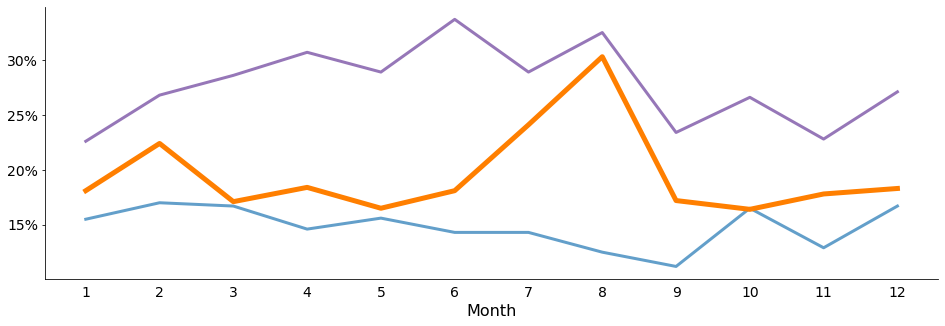

In [ ]:
# BAD REVIEWS (1, 2, 3) - ALL LOCATIONS
# Base Plot
fig, ax = plt.subplots();
fig.set_size_inches(16, 5)

ax.plot(
    df_filtered.loc[df_filtered.Branch_Clean == 'California']['Month'],
    df_filtered.loc[df_filtered.Branch_Clean == 'California']['pct_ratings'],
    label= 'California',
    linewidth = 3,
    alpha = 0.7,
    color = "#2177B4");

ax.plot(
    df_filtered.loc[df_filtered.Branch_Clean == 'HongKong']['Month'],
    df_filtered.loc[df_filtered.Branch_Clean == 'HongKong']['pct_ratings'],
    label= 'Hong Kong',
    linewidth = 5,
    color = "#FF7F00");

ax.plot(
    df_filtered.loc[df_filtered.Branch_Clean == 'Paris']['Month'],
    df_filtered.loc[df_filtered.Branch_Clean == 'Paris']['pct_ratings'],
    label= 'Paris',
    linewidth = 3,
    alpha = 0.7,
    color = "#6A3D9A");

# Styling
# ------------------------------------

## Border
right_side = ax.spines["right"]
right_side.set_visible(False)
top_side = ax.spines["top"]
top_side.set_visible(False)

# Axis
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False         # ticks along the top edge are off
)
plt.xlabel("Month", fontsize=16)
ax.set_xticks(np.arange(1,13))
ax.tick_params(axis="x", labelsize=14)
ax.tick_params(axis="y", labelsize=14)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))


# Save
plt.savefig('plots/bad_reviews_hong_kong.png', dpi=140)

### Reviews by Year
---
Dropped Ratings from 2010 and 2019 -- Incomplete years


In [ ]:
df_ratings_year = disney_year_ratings.toPandas()
df_ratings_year = df_ratings_year.loc[~df_ratings_year['Year'].isin(['2010', '2019'])]

In [ ]:
year_aggregate = df_ratings_year[['Year', 'total_reviews']].groupby('Year').agg('sum').reset_index()
year_aggregate['review_pct'] = (year_aggregate['total_reviews'] / year_aggregate['total_reviews'].sum() * 100).round(1)
year_aggregate['Branch_Clean'] = 'Overall'

In [ ]:
location_aggregate = df_ratings_year[['Year', 'Branch_Clean', 'total_reviews']].groupby(['Year', 'Branch_Clean']).agg('sum').reset_index()

In [ ]:
year_ratings = pd.melt(
    df_ratings_year[['Year', 'rating_1', 'rating_2', 'rating_3', 'rating_4', 'rating_5']],
    id_vars = 'Year'
)

year_ratings.rename(columns = {'variable': 'rating'}, inplace=True)
year_ratings = year_ratings.replace(
    {'rating': {
        'rating_5': '5',
        'rating_4': '4',
        'rating_3': '3',
        'rating_2': '2',
        'rating_1': '1'}
     })


year_ratings = year_ratings.groupby(['Year', 'rating']).sum().reset_index()
year_ratings = year_ratings.sort_values(['rating', 'Year'])

In [ ]:
# calculate y/y percent change. Set to NaN in first year (2011)
year_ratings['pct_change'] = year_ratings['value'].pct_change()
year_ratings.loc[year_ratings.Year == '2011', 'pct_change'] = np.nan

In [ ]:
# Group ratings together
year_ratings_bad = year_ratings[['Year', 'rating', 'value']]\
  .loc[year_ratings.rating.isin(['1','2','3'])]\
  .groupby('Year').sum().reset_index()

year_ratings_good = year_ratings[['Year', 'rating', 'value']]\
  .loc[year_ratings.rating.isin(['4','5'])]\
  .groupby('Year').sum().reset_index()

yy_overall = year_ratings[['Year', 'value']]\
  .groupby('Year').sum().reset_index()

# Get year/year change
year_ratings_bad['pct_change'] = year_ratings_bad['value'].pct_change()
year_ratings_good['pct_change'] = year_ratings_good['value'].pct_change()
yy_overall['pct_change'] = yy_overall['value'].pct_change()

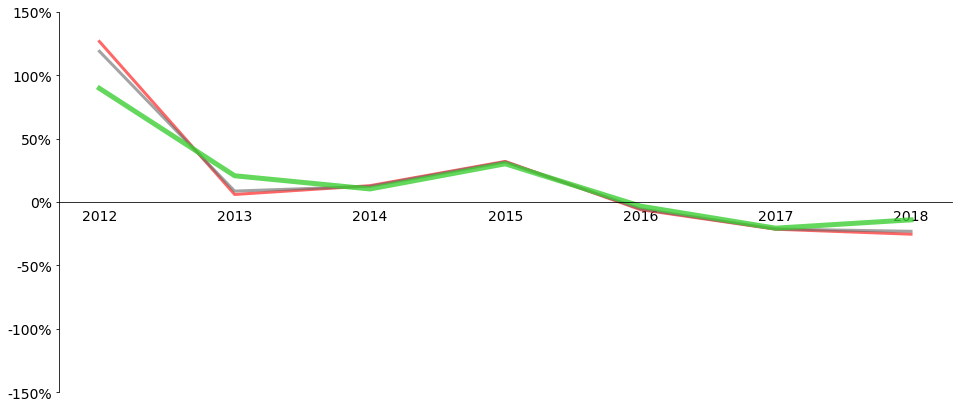

In [ ]:
fig, ax = plt.subplots();
fig.set_size_inches(16, 7)

ax.plot(
    year_ratings_good['Year'],
    year_ratings_good['pct_change'],
    label= 'Bad Reviews',
    linewidth = 3,
    alpha = 0.6,
    color = "#ff0000");

ax.plot(
    yy_overall['Year'],
    yy_overall['pct_change'],
    label= 'Overall',
    linewidth = 3,
    alpha = 0.6,
    color = "#666666");

ax.plot(
    year_ratings_bad['Year'],
    year_ratings_bad['pct_change'],
    label= 'Good Reviews',
    linewidth = 5,
    alpha = 0.8,
    color = "#3dce35");


# Styling
# ------------------------------------

## Border
right_side = ax.spines["right"]
right_side.set_visible(False)
top_side = ax.spines["top"]
top_side.set_visible(False)

# Axis
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False         # ticks along the top edge are off
)

ax.tick_params(axis="x", labelsize=14)
ax.tick_params(axis="y", labelsize=14)
ax.set_ylim([-1.5, 1.5])
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])

# X-Axis to 0
ax.spines['bottom'].set_position('zero')

# Save
plt.savefig('plots/yy_bad_reviews_calfiornia.png', dpi=140)

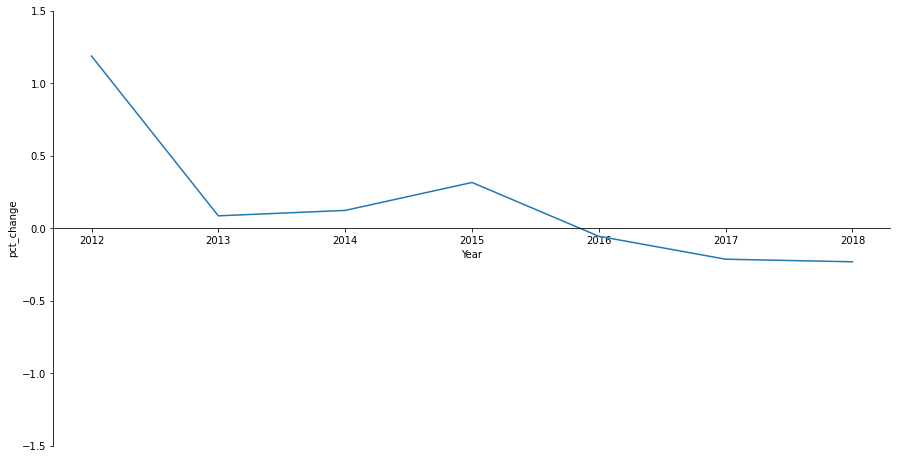

In [ ]:
plt.figure(figsize=(15,8));
g = sns.lineplot(
    data = yy_overall,
    x = 'Year',
    y = 'pct_change',
);

# Styling
# g.set_xticks(range(1,13));
g.set_ybound(-1.5, 1.5)
sns.despine();
g.spines['bottom'].set_position('center')

### Making a Map
---

Keeping code here -- Because of the imbalanced distribution of reviews by country (US + UK = ~57% of all reivews), the map did not turn out nicely. While we could have binned the data, it was easier and more effective communicate a list the top X countries.

In [ ]:
import geopandas

In [ ]:
# GIS datasource: https://hub.arcgis.com/datasets/2b93b06dc0dc4e809d3c8db5cb96ba69_0
zipfile = "../data/World_Countries_(Generalized).zip"
test = geopandas.read_file(zipfile)

In [ ]:
# 162 Countries -- only 15 not found in the map!
rating_country = reivew_country_rating.toPandas()

In [ ]:
rating_country.loc[rating_country.Reviewer_Location == 'U.S. Virgin Islands', 'Reviewer_Location'] = 'US Virgin Islands'
rating_country.loc[rating_country.Reviewer_Location == 'Caribbean Netherlands', 'Reviewer_Location'] = 'Venezuela'
rating_country.loc[rating_country.Reviewer_Location == 'Russia', 'Reviewer_Location'] = 'Russian Federation'
rating_country.loc[rating_country.Reviewer_Location == 'Czechia', 'Reviewer_Location'] = 'Czech Republic'
rating_country.loc[rating_country.Reviewer_Location == 'Democratic Republic of the Congo', 'Reviewer_Location'] = 'Congo DRC'
rating_country.loc[rating_country.Reviewer_Location == 'Myanmar (Burma)', 'Reviewer_Location'] = 'Myanmar'
rating_country.loc[rating_country.Reviewer_Location == 'Brunei', 'Reviewer_Location'] = 'Brunei Darussalam'
rating_country.loc[rating_country.Reviewer_Location == 'The Bahamas', 'Reviewer_Location'] = 'Bahamas'
rating_country.loc[rating_country.Reviewer_Location == 'Falkland Islands (Islas Malvinas)', 'Reviewer_Location'] = 'Falkland Islands'

# Bad Sybmols
rating_country.loc[rating_country.Reviewer_Location == 'C�te d\'Ivoire', 'Reviewer_Location'] = "Côte d'Ivoire"
rating_country.loc[rating_country.Reviewer_Location == 'Cura�ao', 'Reviewer_Location'] = "Curacao"

# Now China
rating_country.loc[rating_country.Reviewer_Location == 'Macau', 'Reviewer_Location'] = 'China'
rating_country.loc[rating_country.Reviewer_Location == 'Hong Kong', 'Reviewer_Location'] = 'China'

# No idea - Dropping
rating_country = rating_country.loc[rating_country.Reviewer_Location != '�land Islands']

In [ ]:
disney_unique_countries = rating_country['Reviewer_Location'].unique()

In [ ]:
# MISSING TAIWAN
disney_unique_countries[~np.isin(disney_unique_countries, test['COUNTRY'])]

array(['Taiwan'], dtype=object)

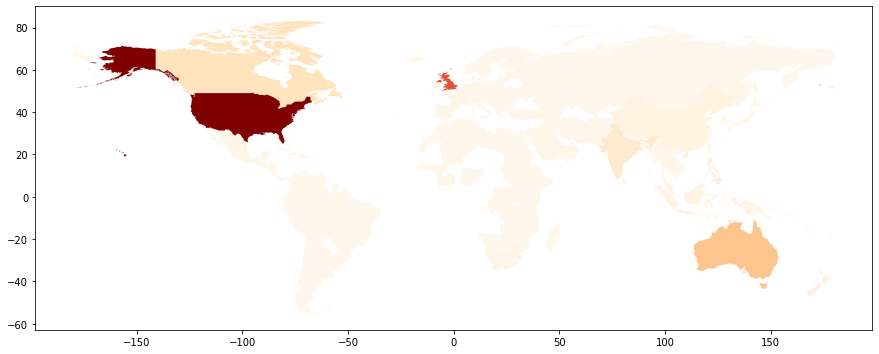

In [ ]:
# Unfortunately due to the imbalance of reviews by country, this isn't very interesting or insightful
# We chose to visualize the top countries with reviews as a bar graph instead (below)

rating_map.plot(
    column='review_count',
    cmap='OrRd',
    figsize=(15,15)
    );

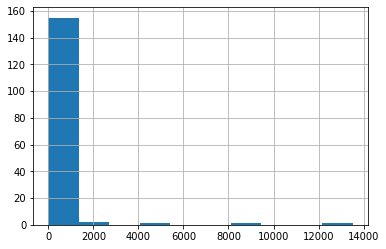

In [ ]:
# Historgram of review count by Country
rating_map['review_count'].hist()

In [ ]:
# Making a bar chart of the Top 10 Countries based on number of reviews
rating_map[['COUNTRY', 'review_count']].sort_values('review_count', ascending=False)[:10]

,COUNTRY,review_count
155,United States,13522.0
90,United Kingdom,9115.0
218,Australia,4412.0
13,Canada,2116.0
194,India,1470.0
239,Philippines,1024.0
230,Singapore,971.0
95,New Zealand,714.0
228,Malaysia,562.0
237,China,515.0


In [ ]:
top_country_reviews = rating_map[['COUNTRY', 'review_count']].sort_values('review_count', ascending=False)[:10]
top_country_reviews = top_country_reviews.sort_values('review_count')

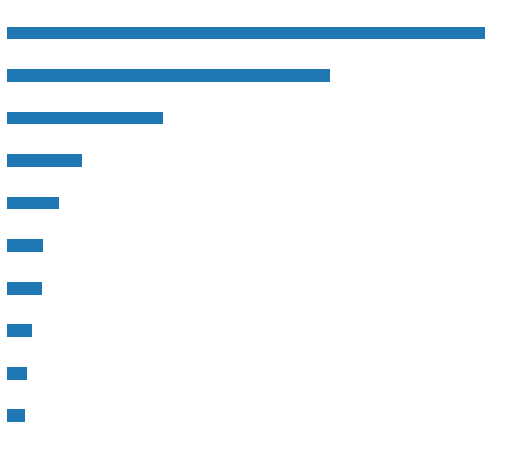

In [ ]:
# Minimalist version of the above. Used to create one of our slides
fig, ax = plt.subplots();
fig.set_size_inches(9, 8)

ax.barh(
    top_country_reviews['COUNTRY'],
    top_country_reviews['review_count'],
    height = .3);

plt.axis('off');

plt.savefig('plots/top_countries_reviews.png', dpi=140)

### Serbian Reviews
---

There are 11 reviews from Serbia. Let's look at them - Rastko is from Serbia

In [ ]:
serbian_reviews = df_serbia.toPandas()

In [ ]:
serbian_reviews

,Review_ID,Rating,Year_Month,Reviewer_Location,Review_Text,Branch,Year,Month,Branch_Clean
0,341128692,2,2016-1,Serbia,This Disney park is the least interesting of a...,Disneyland_HongKong,2016,1,HongKong
1,654902752,4,2019-1,Serbia,"We've been in all Disneyland parks worldwide, ...",Disneyland_Paris,2019,1,Paris
2,609879913,5,2018-6,Serbia,It's so great to have kids so you can experien...,Disneyland_Paris,2018,6,Paris
3,519071931,5,2017-8,Serbia,It`s a 45 minute ride on RER A from Paris. The...,Disneyland_Paris,2017,8,Paris
4,510374282,5,2017-8,Serbia,"Great for both, adults and kids, if you go for...",Disneyland_Paris,2017,8,Paris
5,422467284,5,2015-10,Serbia,If you like Disney cartoons and caracters this...,Disneyland_Paris,2015,10,Paris
6,321874815,5,2015-10,Serbia,Totally amazing experience. I would really be ...,Disneyland_Paris,2015,10,Paris
7,307159144,1,2015-8,Serbia,For this money what you give for Disneyland yo...,Disneyland_Paris,2015,8,Paris
8,248287150,5,2014-3,Serbia,Belongs to the most beautiful thing I've seen....,Disneyland_Paris,2014,3,Paris
9,159058744,5,2012-8,Serbia,Disneyland is with no doubt a place where peop...,Disneyland_Paris,2012,8,Paris


In [ ]:
serbian_reviews['Review_Text'][7]

"For this money what you give for Disneyland you can go in Germany and visit three parks and make your children great happiness!!! Das is very very bad, stuff don't want to speak english you can only understand if you speak French, everything is very expensive, we buy a ticket for only one park, because we knew that that we cannot visit to parks with our children 6 and 9 years old in one day, they was very disappointed!!! For every attraction they have to wait more than one hour, they was very nervous, everything else is nice only for eyes and that's it!!! For picture with Mickey Mouse we have to wait almost two hours, that was crazy, but what is Disneyland visit without picture with Mickey Mouse?! With so many people they have to make 10 Mickey Mouse places not only one, and also with other characters they have to walk through the park that every child have a chance to make picture with them, because this is crazy you can go there and do nothing just waiting... or in every corner go t